<img style="float: left; margin: 30px 15px 15px 15px;" src="https://oci02.img.iteso.mx/Identidades-De-Instancia/ITESO/Logos%20ITESO/Logo-ITESO-Principal.jpg" width="400" height="600" /> 
    
    
##  Selección de Estrategias de Inversión
    
###  Portafolios de Inversión

    Mtro. Sean Nicolás González Vázquez

---

###  Introducción
    


En la clase pasada, aprendimos a realizar el **backtesting** de un portafolio de inversión. Como observamos, esta herramienta es fundamental tanto para evaluar como para seleccionar estrategias de inversión. Sin embargo, aún nos falta profundizar en las métricas de desempeño que complementan este análisis.

En esta clase, nuestro objetivo será extender los conocimientos adquiridos, introduciendo varias métricas financieras clave. Comenzaremos con el concepto de **Beta**, un indicador esencial en la inversión bursátil.

Además, exploraremos otras métricas de desempeño de portafolios que nos permitirán cuantificar tanto el riesgo como el rendimiento desde diferentes perspectivas. Estas métricas incluyen:


+ **Alfa de Jensen**

+ **Ratio de Treynor**

+ **Ratio de Sortino**




Durante esta clase, veremos tanto la teoría detrás de estas métricas como su aplicación práctica. Calcularemos, analizaremos e interpretaremos estos ratios para un conjunto de activos financieros, permitiéndonos tomar decisiones más informadas en la gestión de portafolios. La correcta utilización de estas herramientas mejorará nuestra capacidad de tomar decisiones financieras.

---

###  Función Backtesting




Antes de calcular las métricas de desempeño, comenzaremos por **automatizar el proceso de backtesting** mediante una función en Python. El objetivo es **implementar el mismo portafolio** utilizado en la clase anterior, pero de manera **más eficiente**.

Nuestra función recibirá los **precios de cierre ajustados de los activos** que componen la cartera, la **información del cierre del benchmark**, un **diccionario con los nombres de las estrategias por simular** y sus respectivos **pesos eficientes**, además del **capital a invertir**. Como resultado, la función **devolverá el histórico de la evolución de las estrategias**, junto con su **gráfica correspondiente**.


In [28]:
# Importacion de Librerías
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [29]:
# Descarga de Datos

# Portafolio
tickers=['AAPL', 'BRK-B', 'NKE', 'LLY'] 
# Precios de optimizacion
opt_prices=yf.download(tickers, start='2021-06-20', end='2023-06-20', progress=False)['Close']

# Precios de Backtesting
bt_prices=yf.download(tickers, start='2023-06-20', end='2025-06-20', progress=False)['Close']

# Benchmark
benchmark=yf.download(['^GSPC'], start='2023-06-20', end='2025-06-20', progress=False)['Close']

# Get Optimization Returns 
opt_returns=opt_prices.pct_change().dropna()

In [30]:
# Optimización en Mínima Varianza
def opt_min_var(rets):
    
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    var = lambda w: w.T @ cov @ w
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=var, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

In [31]:
# Función para optimizar Sharpe
def opt_max_sharpe(rets, rf):
    
    E=rets.mean()
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    rs = lambda w: -((w.T @ E - rf/252) / np.sqrt(w.T @ cov @ w))
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=rs, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

In [32]:
# Función Backtesting
def static_backtesting(prices: pd.DataFrame, benchmark: pd.DataFrame, weights: dict, capital: float):
    
    # Obtener rendimientos de precios y benchmark
    rets_assets = prices.pct_change().dropna()
    rets_benchmark = benchmark.pct_change().dropna()
    
    # data frame vacio para llenar historia
    
    df = pd.DataFrame(index=rets_assets.index)
    
    # Obtener evolución para cada estrategia dada
    for strategy in weights.keys():
        # para benchmark
        if strategy == 'benchmark':
            temp = rets_benchmark + 1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values            
    
        # para otras estrategias
    
        else:
            temp = (rets_assets * weights.get(strategy)).sum(axis=1)+1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values    


        
    # Graficar la evolucion para ambos portafolios
    plt.figure(figsize=(12,6))
    plt.plot(df, label=df.keys())
    plt.title('Backtesting of Strategies')
    plt.xlabel('Date')
    plt.ylabel('Portafolio Value')
    plt.legend()
    plt.show()


    return df

In [33]:
# Optimizar pesos
w_minvar = opt_min_var(opt_returns)
w_maxsharpe = opt_max_sharpe(opt_returns, 0.045)

In [34]:
# Diccionario con estrategias por probar
w_dict = {
    'Min Varianza': w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Benchmark': 1
}

In [35]:
w_dict.get('Min Varianza') # Obtener los pesos de una estrategia correspondiente
w_dict.keys() # Acceder a los nombres de las estartegias
w_dict.values() #Acceder a los valores (pesos) correspondientes a cada estrategia


dict_values([array([6.39935086e-03, 7.38281084e-01, 2.55319565e-01, 1.21972744e-19]), array([0.13430228, 0.        , 0.86569772, 0.        ]), 1])

In [36]:
# Definir capital
capital = 1000000

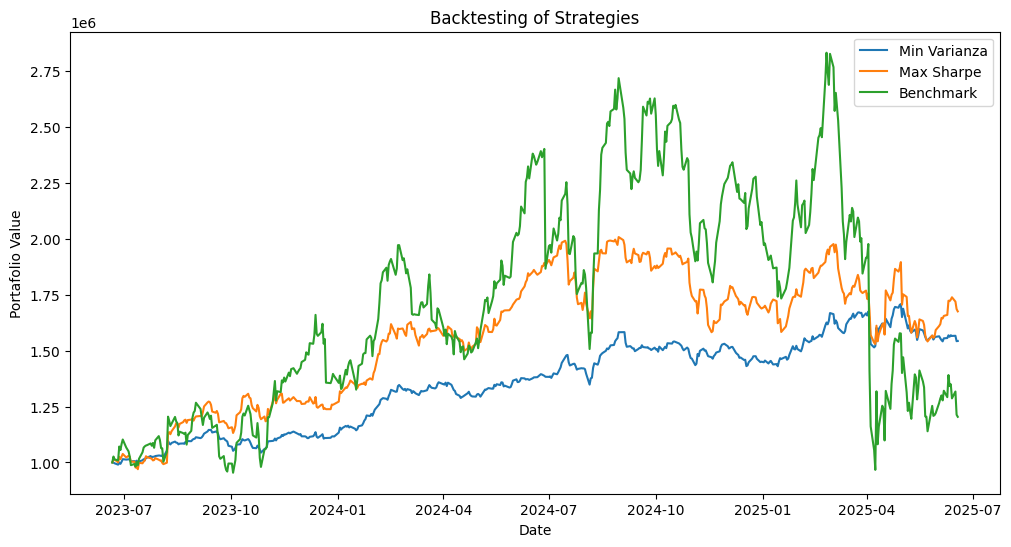

In [37]:
# Utilizar función de backtesting
history = static_backtesting(bt_prices, benchmark, w_dict, capital)

Además, necesitamos una **función para simplificar el cálculo de las métricas de desempeño**. Esta función recibirá un **data frame con la evolución histórica de las estrategias** y la **tasa libre de riesgo**, devolviendo un **data frame con las métricas de desempeño por estrategia**.

In [38]:
# Función para las metricas de desempeño

def performance_metrics(history, rf):
        
    # Rendimiento de los portafolios
    rets = history.pct_change().dropna()

    # En un DataFrame
    metrics = pd.DataFrame(index=rets.columns)

    # Métricas de Desempeño

    # Rend Prom
    metrics['Rendimiento Promedio anual ']= rend_prom = rets.mean() * 252 * 100  # Anualizado    
    
    # Volatilidad
    metrics['Volatilidad anual']= Vol = rets.std() *np.sqrt(252) *100  

    # Radio de Sharpe
    metrics['Sharpe Ratio']= Ratio_sharpe = (metrics['Rendimiento Promedio anual '] - rf) / metrics['Volatilidad anual']
    
    # Downside 
    
    metrics['Downside risk']= downside = (rets[rets<0].fillna(0)).std() *np.sqrt(252) *100  

    # Upside
    
    metrics['Upside risk']=upside = (rets[rets>0].fillna(0)).std() *np.sqrt(252) *100

    # Omega
    metrics['Omega'] = Omega = (upside/downside)
    

    return metrics.T


In [39]:
# Calcular métricas con la función
Metricas = performance_metrics(history, 4.5)
Metricas

,Min Varianza,Max Sharpe,Benchmark
Rendimiento Promedio anual,23.210841,30.807351,38.529366
Volatilidad anual,16.410556,31.112695,76.151985
Sharpe Ratio,1.140171,0.845550,0.446861
Downside risk,9.782016,17.979918,47.727439
Upside risk,10.324772,20.591499,47.108701
Omega,1.055485,1.145250,0.987036


---

###  Beta
    
La **beta es una medida de sensibilidad de un activo (o portafolio) ante fluctuaciones de mercado**. Es un indicador clave del riesgo sistemático, es decir, el riesgo que no se puede diversificar. Se calcula de la siguiente manera:

$$\beta = \frac{cov(Activo, Mercado)}{var(Mercado)}$$

$$\beta = \frac{\sigma_{i, M}}{\sigma^2_M}$$

Donde:
    
+ $\sigma_{i, M}$: Covarianza del activo (o portafolio) con el mercado.
    
+ $\sigma^2_M$: Varianza del mercado.
    
La interpretación de la Beta depende de su valor, existen tres casos específicos:

| **Valor de Beta** | **Interpretación**                                                                 |
|------------------|-------------------------------------------------------------------------------------|
| **Beta > 1**     | Activo o portafolio agresivo. Mayor impacto de los movimientos del mercado. |
| **Beta = 1**     | El activo se mueve en línea con el mercado.                                          |
| **Beta < 1**     | Activo o portafolio defensivo. Menor impacto de los movimientos del mercado. |



In [40]:
# Obtener covarianzas de estrategias con el mercado
rets_history = history.pct_change().dropna()
cov_matrix = rets_history.cov()
covs = cov_matrix['Benchmark']

In [41]:
# Obtener varianza del Mercado
varianza_market = covs['Benchmark']

In [42]:
# Obtener betas 
Betas = covs / varianza_market
Betas

Min Varianza    0.164030
Max Sharpe      0.292718
Benchmark       1.000000
Name: Benchmark, dtype: float64

---

###  Alfa de Jensen

El Alfa de Jensen mide el **rendimiento de un portafolio en relación con su rendimiento esperado ajustado por riesgo sistématico**. Indica si el portafolio ha tenido un rendimiento superior o inferior al esperado.


$$\alpha_J = R_p - [ R_f + \beta \cdot (R_m - R_f)] $$

Donde:
- $R_p$: Rendimiento del portafolio
- $R_f$: Tasa libre de riesgo
- $\beta$: Beta del portafolio en relación con el mercado
- $R_m$: Rendimiento del mercado

El Alfa de Jensen es una herramienta clave para evaluar el desempeño de un portafolio o gestor, mostrando si se están generando rendimientos por encima de lo que se esperaría de un gestor de portafolios en función del riesgo sistemático.


En términos simples **indica que tan bueno es un gestor para generar rendimientos por encima a los esperados**. Se expresa en porcentaje.

In [43]:
# Obtener rendimientos para todos los portafolios (estrategias)
R_p = rets_history.mean()*252*100
R_p

Min Varianza    23.210841
Max Sharpe      30.807351
Benchmark       38.529366
dtype: float64

In [44]:
# Definir tasa libre de riesgo
rf = 4.5

In [45]:
# Obtener rendimiento de mercado
R_m = R_p['Benchmark']
R_m

38.52936616709743

In [46]:
# Obtener alfa de jensen

alpha_Jensen = R_p - (rf+Betas * (R_m - rf))
alpha_Jensen

Min Varianza    13.128998
Max Sharpe      16.346330
Benchmark        0.000000
dtype: float64

---

###  Ratio de Treynor
    
El Ratio de Treynor es una métrica que mide el **rendimiento ajustado por riesgo sistemático** (Beta) de un portafolio. A diferencia del ratio de Sharpe, que ajusta el rendimiento en función de la volatilidad total, el ratio de Treynor solo toma en cuenta el riesgo que proviene del mercado, es decir, el riesgo no diversificable. Mide las unidades de rendimiento generadas por unidad de riesgo sistemático asumido.


$$T = \frac{R_p - R_f}{\beta}$$

Donde:
    
- $R_p$: Rendimiento del portafolio
- $R_f$: Tasa libre de riesgo
- $\beta$: Beta del portafolio



El ratio de Treynor es útil para comparar portafolios con diferentes niveles de exposición al riesgo sistemático. Un ratio más alto indica un mejor desempeño ajustado por el riesgo de mercado.

In [47]:
# Obtener Ratio de Treynor
Ratio_Treynor = (R_p - rf) / Betas
Ratio_Treynor

Min Varianza    114.069509
Max Sharpe       89.872559
Benchmark        34.029366
dtype: float64

In [48]:
Ratio_Sharpe = Metricas.loc['Sharpe Ratio']
Ratio_Sharpe

Min Varianza    1.140171
Max Sharpe      0.845550
Benchmark       0.446861
Name: Sharpe Ratio, dtype: float64

---

###  Ratio de Sortino
    
    
El Ratio de Sortino es una variación del ratio de Sharpe que ajusta el **rendimiento de un portafolio en función de su riesgo a la baja** (downside risk), es decir, solo tiene en cuenta la volatilidad de los rendimientos que están por debajo de un cierto umbral o rendimiento objetivo. Mide las unidades de rendimiento generadas por unidad de downside risk asumida.

$$S = \frac{R_p - R_f}{\sigma_d}$$

Donde:
- $R_p$:  Rendimiento del portafolio
- $R_f$:  Tasa libre de riesgo
- $\sigma_d$:  Desviación estándar de los rendimientos por debajo de un rendimiento objetivo (volatilidad negativa)

El ratio de Sortino solo penaliza el riesgo de caída del rendimiento, lo que lo hace más preciso cuando se evalúa el riesgo relacionado con las pérdidas en lugar de la volatilidad total.

In [51]:
# Obtener downside risk
Downside_Risk = Metricas.loc['Downside risk']
Downside_Risk


Min Varianza     9.782016
Max Sharpe      17.979918
Benchmark       47.727439
Name: Downside risk, dtype: float64

In [52]:
# Obtener Ratio de Sortino
Ratio_Sortino = (R_p - rf) / Downside_Risk
Ratio_Sortino


Min Varianza    1.912780
Max Sharpe      1.463152
Benchmark       0.712994
dtype: float64